<a href="https://colab.research.google.com/github/ayushksingh28/transformers_scratch/blob/main/Multi_Head_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
sequence_length = 4
batch_size = 1
input_dim = 512
d_model = 512 #output of the attention model
x = torch.randn((batch_size, sequence_length, input_dim))

In [4]:
x.size()

torch.Size([1, 4, 512])

In [5]:
qkv_layer = nn.Linear(input_dim, 3*d_model)

In [6]:
qkv = qkv_layer(x)

In [7]:
qkv.shape

torch.Size([1, 4, 1536])

Text(0.5, 1.0, 'qkv_distribution')

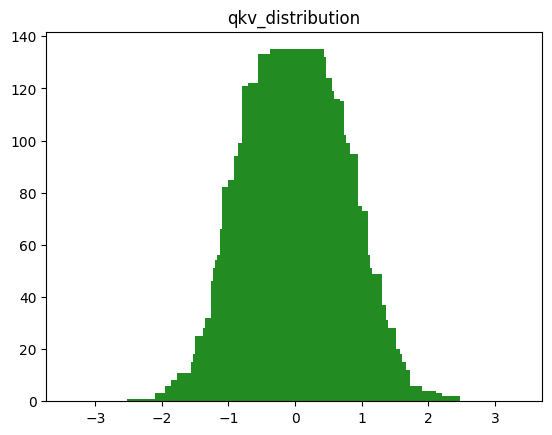

In [8]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins = 200, min=-3, max=3)
x_val = np.arange(-1, 1, 0.01) * 3
plt.bar(x_val, y_val, align = "center", color = ["forestgreen"])
plt.title("qkv_distribution")

In [9]:
num_heads = 8
head_dim = d_model // num_heads
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3 * head_dim)

In [25]:
qkv.shape

torch.Size([1, 4, 8, 192])

In [26]:
qkv = qkv.permute(0, 2, 1, 3)
qkv.shape

torch.Size([1, 8, 4, 192])

In [27]:
q, k, v = qkv.chunk(3, dim=-1)
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

#Self-Attention for Multiple Heads

In [28]:
import math

In [29]:
d_k = q.size()[-1]
scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
scaled.shape

torch.Size([1, 8, 4, 4])

In [30]:
k.T.shape

torch.Size([64, 4, 8, 1])

In [31]:
y = torch.randn(2, 3)
torch.transpose(y, 0, 1)

tensor([[ 0.5245, -1.3092],
        [ 1.0542,  0.5634],
        [ 0.3287, -0.1835]])

In [32]:
torch.transpose(y, 1, 0)

tensor([[ 0.5245, -1.3092],
        [ 1.0542,  0.5634],
        [ 0.3287, -0.1835]])

In [33]:
k.transpose(-1, -2) == k.transpose(-2, -1)

tensor([[[[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         ...,

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, 

In [34]:
k.transpose(-1, -2).shape

torch.Size([1, 8, 64, 4])

In [35]:
mask = torch.full(scaled.size() , float('-inf'))
mask = torch.triu(mask, diagonal=1)
mask[0][1] # mask for input to a single head

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [36]:
(scaled + mask)[0][0]

tensor([[ 0.1103,    -inf,    -inf,    -inf],
        [ 0.3438, -0.4219,    -inf,    -inf],
        [-0.3889, -0.5614, -0.0471,    -inf],
        [-0.4755,  0.0845, -0.1721,  0.4225]], grad_fn=<SelectBackward0>)

In [37]:
scaled += mask

In [38]:
np.exp(0.5596) / (np.exp(0.5596) + np.exp(0.0404))

0.6269606805367254

In [39]:
attention = F.softmax(scaled, dim=-1)

In [40]:
attention.shape

torch.Size([1, 8, 4, 4])

In [42]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.6826, 0.3174, 0.0000, 0.0000],
        [0.3078, 0.2590, 0.4332, 0.0000],
        [0.1524, 0.2669, 0.2065, 0.3742]], grad_fn=<SelectBackward0>)

In [44]:
values = torch.matmul(attention, v)
values.shape

torch.Size([1, 8, 4, 64])

#Function

In [45]:
import math

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [46]:
values, attention = scaled_dot_product(q, k, v, mask=mask)

In [47]:
attention.shape

torch.Size([1, 8, 4, 4])

In [48]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.6826, 0.3174, 0.0000, 0.0000],
        [0.3078, 0.2590, 0.4332, 0.0000],
        [0.1524, 0.2669, 0.2065, 0.3742]], grad_fn=<SelectBackward0>)

In [50]:
values.size()

torch.Size([1, 8, 4, 64])

In [51]:
values = values.reshape(batch_size, sequence_length, num_heads * head_dim)
values.size()

torch.Size([1, 4, 512])

In [52]:
linear_layer = nn.Linear(d_model, d_model)

In [53]:
out = linear_layer(values)

In [54]:
out.shape

torch.Size([1, 4, 512])

In [55]:
out

tensor([[[-0.3849, -0.3666, -0.2204,  ...,  0.2603, -0.0469,  0.1961],
         [-0.3815,  0.0576,  0.0033,  ..., -0.0957, -0.6332, -0.0270],
         [-0.0156, -0.0149,  0.0557,  ..., -0.1234,  0.5941, -0.4712],
         [ 0.4354, -0.6259, -0.1741,  ...,  0.1176,  0.3189,  0.2415]]],
       grad_fn=<ViewBackward0>)

#Class

In [56]:
import torch
import torch.nn as nn
import math

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

class MultiHeadAttention(nn.Module):

    def __init__(self, input_dim, d_model, num_heads):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(input_dim , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        batch_size, sequence_length, input_dim = x.size()
        print(f"x.size(): {x.size()}")
        qkv = self.qkv_layer(x)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.permute(0, 2, 1, 3)
        print(f"qkv.size(): {qkv.size()}")
        q, k, v = qkv.chunk(3, dim=-1)
        print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}, ")
        values, attention = scaled_dot_product(q, k, v, mask)
        print(f"values.size(): {values.size()}, attention.size:{ attention.size()} ")
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        print(f"values.size(): {values.size()}")
        out = self.linear_layer(values)
        print(f"out.size(): {out.size()}")
        return out

#Input

In [57]:
input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 30
sequence_length = 5
x = torch.randn( (batch_size, sequence_length, input_dim) )

model = MultiHeadAttention(input_dim, d_model, num_heads)
out = model.forward(x)

x.size(): torch.Size([30, 5, 1024])
qkv.size(): torch.Size([30, 5, 1536])
qkv.size(): torch.Size([30, 5, 8, 192])
qkv.size(): torch.Size([30, 8, 5, 192])
q size: torch.Size([30, 8, 5, 64]), k size: torch.Size([30, 8, 5, 64]), v size: torch.Size([30, 8, 5, 64]), 
values.size(): torch.Size([30, 8, 5, 64]), attention.size:torch.Size([30, 8, 5, 5]) 
values.size(): torch.Size([30, 5, 512])
out.size(): torch.Size([30, 5, 512])
